# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

### Attention!
* For tasks where <ins>text answer</ins> is required **Russian language** is **allowed**.
* If a task asks you to describe something (make coclusions) then **text answer** is **mandatory** and **is** part of the task
* **Do not** upload the dataset to the grading system (we already have it)
* We **only** accept **ipynb** notebooks. If you use Google Colab then you'll have to download the notebook before passing the homework
* **Do not** use python loops instead of NumPy vector operations over NumPy vectors - it significantly decreases performance (see why https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/), will be punished with -0.25 for **every** task. 


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hands. 

### Task 1 <a id="task1"></a> (0.5 points)

Implement the function `H()` which calculates impurity criterion. We will be training regression tree, therefore, impurity criterion will be variance.

* You cannot use loops
* If `y` is empty, the function should return 0

In [2]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if len(y) == 0:
        return 0
    return np.var(y)

In [3]:
# Test the function
assert np.allclose(H(np.array([4, 2, 2, 2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [4]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """
    bools = X[:,j] < t
    left = y[bools]
    right = y[~bools]
    size = X.shape[0]
    return (H(left)*left.size + H(right)*right.size) / size

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [5]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self, depth=None):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = depth
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'.format(self.column, self.threshold, self.prediction)
        return node_desc

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
    
    def _more_tags(self):
        return {
            'requires_y': False
        }
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels.
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y) 
        
        for split_column in range(X.shape[1]):
          column = X[:,split_column]
          for threshold in column:
            cost = Q(X, y, split_column, threshold)
            if cost < best_cost:
              best_cost = cost
              best_split_column = split_column
              best_threshold = threshold

        if best_split_column == None:
          return None, None, None, None, None, None
        
        bools = X[:,best_split_column] < best_threshold
        return best_split_column, best_threshold, X[bools,:], y[bools], X[~bools,:], y[~bools]
  
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth` and `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if self.is_terminal(node, y):
            node.is_terminal = True
            return

        best_split_column, best_threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)
        if best_split_column == None:
          node.is_terminal = True
          return
        
        node.column = best_split_column
        node.threshold = best_threshold
        node.left = Node(node.depth + 1)
        node.right = Node(node.depth + 1)
        node.left.prediction = np.mean(y_left)
        node.right.prediction = np.mean(y_right)

        self.grow_tree(node.left, X_left, y_left)
        self.grow_tree(node.right, X_right, y_right)
        

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        # Check the input
        if y is None:
            raise ValueError('Y should not be None')
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]
        
        # Initialize the tree (root node, depth = 0)
        self.tree_ = Node()                             
        self.tree_.depth = 0                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """

        if node.is_terminal:
          return node.prediction

        if x[node.column] < node.threshold:
          return self.get_prediction(node.left, x)
        else:
          return self.get_prediction(node.right, x)
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [7]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($70\%$) and test ($30\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model 

P.S. Depth of the tree is equal to the longest path from the root note to the leaf. Thus, tree with depth 1 will have exactly 1 split. 

P.P.S. Both fitted model and the training points should be on the same plot

In [31]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

data = load_boston()
Xtrain, Xtest, ytrain, ytest = train_test_split(data.data, data.target, test_size=0.3, random_state=122)

In [9]:
def plot_tree_split(tree):
  ypred = tree.predict(Xtrain)
  col = tree.tree_.column
  jump = tree.tree_.threshold
  l = tree.tree_.left.prediction
  r = tree.tree_.right.prediction
  xcol = Xtrain[:, col]

  plt.xlabel(data.feature_names[col])
  plt.ylabel("target")

  plt.scatter(xcol, ytrain, label="actual")
  plt.scatter(xcol, ypred, label="predicted", s=20)
  if tree.max_depth == 1:
    plt.plot([min(xcol), jump, jump, max(xcol)], [l,l,r,r], label="model", c="darkgreen", linewidth=3)
  plt.legend()
  plt.show()

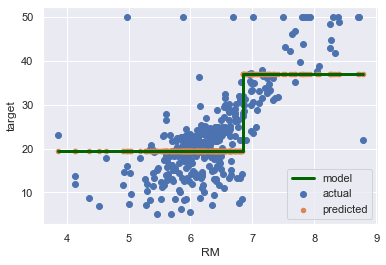

In [10]:
tree = MyDecisionTreeRegressor(max_depth=1)
tree.fit(Xtrain, ytrain)
plot_tree_split(tree)

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters (`max_depth` and `min_samples_split`) on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `RMSE` on test dataset and hyperparameters of the best estimator. 

In [11]:
from sklearn.model_selection import GridSearchCV

params = {'max_depth': [1, 2, 5, 10], 'min_samples_split': [2, 5, 10, 20, 50, 100, 200]}
gscv = GridSearchCV(MyDecisionTreeRegressor(), params, scoring='neg_root_mean_squared_error', cv=5, n_jobs=-1)
gscv.fit(Xtrain, ytrain)
gscv.best_params_

{'max_depth': 10, 'min_samples_split': 2}

In [12]:
# код из прошлой домашки
from mpl_toolkits.mplot3d import Axes3D
%config InlineBackend.figure_formats = ['svg']

def destringify_array(arr):
  if type(arr[0]) == str:
    return np.arange(len(arr))
  else:
    return arr

def plot3d(gscv, title=None, xscale="linear", yscale="linear"):
  keys = list(gscv.best_params_.keys())
  xarr = destringify_array(gscv.param_grid[keys[0]])
  yarr = destringify_array(gscv.param_grid[keys[1]])
  xshape = len(xarr)
  yshape = len(yarr)

  if xscale == "log":
    xarr = np.log(xarr)
  if yscale == "log":
    yarr = np.log(yarr)
  
  z = np.reshape(gscv.cv_results_["mean_test_score"], (xshape,yshape)).T
  mesh = np.meshgrid(xarr, yarr)

  ax = plt.axes(projection="3d")

  ax.set_xlabel(keys[0].replace('_', ' '))
  ax.set_xticks(xarr)
  ax.set_xticklabels(gscv.param_grid[keys[0]])
  ax.set_ylabel(keys[1].replace('_', ' '))
  ax.set_yticks(yarr)
  ax.set_yticklabels(gscv.param_grid[keys[1]])
  ax.set_zlabel("Score")
  ax.set_title(title)

  ax.scatter3D(*mesh, z, c="green")
  ax.plot_surface(*mesh, z, alpha=0.3)
  plt.show()

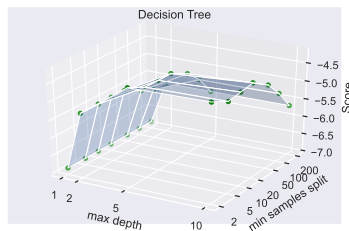

In [13]:
plot3d(gscv, "Decision Tree", yscale="log")

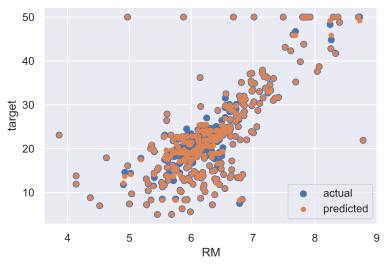

RMSE =  5.865483544678845


In [14]:
from sklearn.metrics import mean_squared_error

tree = MyDecisionTreeRegressor(**gscv.best_params_)
tree.fit(Xtrain, ytrain)
plot_tree_split(tree)
rmse = mean_squared_error(ytest, tree.predict(Xtest), squared=False)
print("RMSE = ", rmse)

### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias^2 and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n\_iter}$. Each $X_i$ has $N$ observations (randomly selected from the original dataset with replacement)
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n\_iter}$, which contains all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on observations from $X_i$s and compute predictions on points from $Z_i$s
4. For a given *object* $x_n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $x_n$ was in OOB)
     - variance: variance of the predictions (predictions of the algorithms, for which $x_n$ was in OOB)
5. Average bias^2 and variance over all the points


**Consider a toy example.** You are given a dataset with 5 observations: $((x_1 ,y_1), (x_2, y_2), (x_3, y_3), (x_4, y_4), (x_5, y_5))$, where $x_i$ is a vector of features, $y_i$ is a target variable . And choose `n_iter` to be 3. 
* Example of bootstrapped samples:
$$X_1 = (x_2, x_5, x_2, x_3, x_2, x_5)$$
$$X_2 = (x_5, x_2, x_4, x_4, x_1, x_5)$$
$$X_3 = (x_1, x_3, x_1, x_4, x_3, x_1)$$

* Corresponding OOB samples:
$$Z_1 = (x_1, x_4)$$
$$Z_2 = (x_3)$$
$$Z_3 = (x_2, x_5)$$

* Fit models using $X_1$, $X_2$ and $X_3$ as training data. Use 1st model to make predictions for points from $Z_1$, second - for $Z_2$, etc. and use these predictions to estimate bias and variance. 

    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations `n_iter`). All other operations should be vectorized. 

P.S. These numpy functions might be usefull here `np.nanmean`, `np.nanstd` (but you are not obliged to use them). 

In [15]:
import warnings

def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias^2 and variance of the `estimator`. Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, )
        1D array with the object labels.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """

    size = x.shape[0]
    preds = np.full((size, n_iter), np.nan)
    
    for i in range(n_iter):
      idx = np.random.choice(size, size)
      inv = np.ones(size, dtype=bool)
      inv[idx] = False

      estimator.fit(x[idx, :], y[idx])
      pred = estimator.predict(x[inv, :])
      preds[inv, i] = pred

    with warnings.catch_warnings():
      warnings.simplefilter("ignore", category=RuntimeWarning)
      bias2 = np.nanmean((np.nanmean(preds, axis=1) - ytrain)**2)
      variance = np.nanmean(np.nanvar(preds, axis=1))

    return bias2, variance

In [16]:
# Test
np.random.seed(413)
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, Xtrain, ytrain, 10)

(20.06692515760432, 7.693611192171648)

### Task 7 <a id="task7"></a>  (0.5 points = 0.25 for code + 0.25 for comments)

Compute bias and variance for the trees of different depths. Plot how bias and variance change as depth increases. 

Comment on what you observe, how does your result correspond to what we have discussed in class?

In [17]:
np.random.seed(612)
depths = np.arange(1, 11)
biasvar = np.array([
  get_bias_variance(MyDecisionTreeRegressor(max_depth=depth), Xtrain, ytrain, 10)
  for depth in depths
])
biasvar

array([[46.01744464,  7.61009699],
       [28.60121657,  4.81766281],
       [22.38378937,  6.71911777],
       [19.55081768,  8.99181139],
       [18.92937485,  7.6351783 ],
       [21.14453118,  8.09845223],
       [14.62455422,  6.73316738],
       [19.48269553, 11.81873949],
       [19.5178747 , 11.27359202],
       [20.01485875,  8.11726217]])

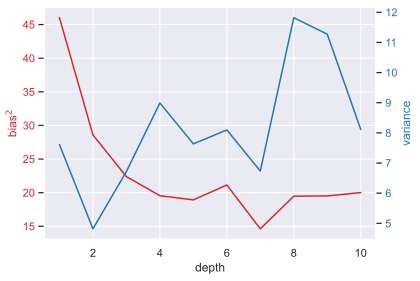

In [18]:
def colored_label_plot(ax, x, y, color, label):
  ax.set_ylabel(label, color=color)
  ax.plot(x, y, color=color, label=label)
  ax.tick_params(axis='y', labelcolor=color)

def biplot(x, y1, y2, labels=["depth", "bias$^2$", "variance"]):
  fig, ax = plt.subplots()
  ax.set_xlabel(labels[0])

  colored_label_plot(ax, x, y1, 'tab:red', labels[1])
  ax2 = ax.twinx()
  ax2.grid(False)
  colored_label_plot(ax2, x, y2, 'tab:blue', labels[2])

  fig.tight_layout()
  # plt.legend()
  plt.show()

# plt.locator_params(axis='y', nbins=6)
biplot(depths, biasvar[:,0], biasvar[:,1])

На графике можно увидеть как с увеличением максимальной глубины дерева уменьшается $\textrm{bias}^2$ и увиличивается variance, как и в теории должно случится с решительными (decision) деревьями.
У нас получается компромисс (tradeoff) между bias и variance, то есть нам приходится выбирать что для нас важнее.

### Task 8 <a id="task8"></a>  (0.5 points = 0.25 for code + 0.25 for comments)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [19]:
from sklearn.ensemble import BaggingRegressor

breg = BaggingRegressor(MyDecisionTreeRegressor(7), random_state=122)
get_bias_variance(breg, Xtrain, ytrain, 10)

(15.059070113833831, 2.9588001198345752)

> Such a meta-estimator can typically be used as a way to reduce the variance

*it did in fact reduce variance*

BaggingRegressor сильно уменшил variance и почти не изменил bias, как в принципе он и должен делать в теории.
С теорией он совподяет, я думаю, потому что у нас нормальная ситуация и стандартные значения и какбы нет особо причин не совподять с теорией, если она праивльная.

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task. 

In [2]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('thyroid_disease.csv')

le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,...,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,...,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,...,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other
3,70.0,F,t,f,f,f,f,f,f,f,...,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other
4,70.0,F,f,f,f,f,f,f,f,f,...,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (take a look at the argument `drop` in [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to figure out the best way to apply OHE to binary variables)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer)) to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transorm1, column_names1),
    ('name2', transorm2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_transform = make_pipeline(
                                 transform_1,
                                 transform_2
                                )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns in the dataset. 

In [7]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.model_selection import train_test_split

In [8]:
# ищем колокни где нанов больше 10%
tmp = X.isna().sum(axis=0) / X.shape[0]
names = list(tmp[tmp > 0.10].index)
print("колонки с нанами: ", names)

# ищем колокни где только одно уникальное значение
tmp = X.apply(pd.Series.nunique)
names += list(tmp[tmp == 1].index)
print("безполезные колонки: ", names)

X_train1, X_test1, y_train, y_test = train_test_split(X.drop(columns=names), y, test_size=0.2, random_state=413)

колонки с нанами:  ['T3', 'T4U', 'FTI', 'TBG']
безполезные колонки:  ['T3', 'T4U', 'FTI', 'TBG', 'TBG_measured']


In [9]:
print(dict(X_train1.select_dtypes(object).isna().sum(axis=0)))

{'sex': 116, 'on_thyroxine': 0, 'query_on_thyroxine': 0, 'on_antithyroid_medication': 0, 'sick': 0, 'pregnant': 0, 'thyroid_surgery': 0, 'I131_treatment': 0, 'query_hypothyroid': 0, 'query_hyperthyroid': 0, 'lithium': 0, 'goitre': 0, 'tumor': 0, 'hypopituitary': 0, 'psych': 0, 'TSH_measured': 0, 'T3_measured': 0, 'TT4_measured': 0, 'T4U_measured': 0, 'FTI_measured': 0, 'referral_source': 0}


Из всех категорических колонок NaN-ы есть только в колонке `sex`, потому что все остальные на самом деле булы закодированные как `t` и `f`.
Тут возникает сложная моральная диллема как это лучше всего заполнять.
У нас есть пять разных вариантов:
1. Если просто прогнать `OneHotEncoder()`, получется one hot vector из трёх елементов.
Такой же результат у нас получится если мы пропишем `SimpleImputer(strategy='constant', fill_value='NB')`.
    * `F⠀⠀` → `[1, 0, 0]`
    * `M⠀⠀` → `[0, 1, 0]`
    * `NaN` → `[0, 0, 1]`
2. Если делать пайплайн из `SimpleImputer()` и `OneHotEncoder()`, на что нам намикает условие строчкой `from sklearn.impute import SimpleImputer`, получется один елемент. 
Тут NaN заменяется на F, потому что в нашем датасете F-ов в два раза больше чем M-ов.
    * `F⠀⠀` → `0`
    * `M⠀⠀` → `1`
    * `NaN` → `0`
3. Также можно придумать заполнять NaN рандомом в пропорциие с частотой в датасете, но `SimpleImputer()` так не умеет и нам придётся писать свой Imputer.
    * `F⠀⠀` → `0`
    * `M⠀⠀` → `1`
    * `NaN` → `rand() < count(M)/count(M+F)`
4. Или прописать его всегда $0.5$, но чтобы получить такой результат, нам нужно будет писать свой `OneHotEncoder()`.
    * `F⠀⠀` → `0`
    * `M⠀⠀` → `1`
    * `NaN` → `0.5`
5. Тогда уж можно сделать некий гибрид one hot vector-а с неуверенностью.
    * `F⠀⠀` → `[1, 0]`
    * `M⠀⠀` → `[0, 1]`
    * `NaN` → `[0, 0]`

> P.S. Choose your favourite way to fill missing values.

Я выбрал первый вариант 🙃

In [10]:
# можно ещё взять SimpleImputer(strategy="most_frequent")
pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value='Other'), OneHotEncoder(drop='if_binary'))
column_transformer = ColumnTransformer([
  ('cat', pipeline, make_column_selector(dtype_include=object)),
  ('num', SimpleImputer(),  make_column_selector(dtype_include=float)),
], remainder='passthrough')

# Transform the data
X_train = column_transformer.fit_transform(X_train1)
X_test = column_transformer.transform(X_test1)

In [11]:
X_train.shape

(3017, 30)

### Task 2 <a id="task2_2"></a> (0.7 points  = 0.4 for code + 0.3 for comments)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice.
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [14]:
# баланс классов у нас просто ужасный
np.unique(y_train, return_counts=True)[1]

array([2835,  182], dtype=int64)

In [41]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score, roc_curve

def show_results(test_y, pred, name="SVC", labels=['negative', 'positive']):
  print(f"{name} Precision:  {precision_score(test_y, pred, average='macro', zero_division=0):.2f}")
  print(f"{name} Recall:     {recall_score(test_y, pred, average='macro'):.2f}")
  print(f"{name} F1-measure: {f1_score(test_y, pred, average='macro'):.2f}")
  print(f"{name} Accuracy:   {accuracy_score(test_y, pred):.2f}")
  
  sns.heatmap(data=confusion_matrix(test_y, pred), annot=True, fmt="d", cbar=False, xticklabels=labels, yticklabels=labels)
  plt.ylabel("True")
  plt.xlabel("Predicted")
  plt.title(f"Confusion matrix for {name}")
  plt.show()

def try_models(models, scoring=f1_score, cv=False, matrix=False):
  scoring_name = scoring.__name__.split('_')[0]
  for m in models:
    name = type(m).__name__.replace('Classifier', '')

    if cv:
      cvscore = cross_validate(m, X_train, y_train, cv=5, scoring=scoring_name, return_estimator=True)
      maxidx = np.argmax(cvscore["test_score"])
      model = cvscore['estimator'][maxidx]
      print(f"{name} cross_validate:", cvscore["test_score"])
    else:
      model = m.fit(X_train, y_train)

    test_pred = model.predict(X_test)
    train_pred = model.predict(X_train)
    test_score = scoring(y_test, test_pred)
    train_score = scoring(y_train, train_pred)
    print(f"{name} оверфиттинг: {train_score > test_score} ({train_score:.2f} > {test_score:.2f})")
    results.append((test_score, model))

    if matrix:
      show_results(y_test, test_pred, name)

In [46]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

scoring = f1_score
models = [
  GradientBoostingClassifier(),
  RandomForestClassifier(class_weight="balanced_subsample"),
  DecisionTreeClassifier(class_weight="balanced"),
  SVC(class_weight="balanced"),
  LogisticRegression(class_weight="balanced", max_iter=10000),
]
results = []

np.random.seed(122)
try_models(models, cv=True)

GradientBoosting cross_validate: [0.1        0.20689655 0.25925926 0.27906977 0.2173913 ]
GradientBoosting оверфиттинг: True (0.45 > 0.11)
RandomForest cross_validate: [0.0952381  0.16666667 0.23076923 0.27272727 0.25      ]
RandomForest оверфиттинг: True (0.90 > 0.14)
DecisionTree cross_validate: [0.28125    0.24       0.275      0.35483871 0.35135135]
DecisionTree оверфиттинг: True (0.89 > 0.30)
SVC cross_validate: [0.26966292 0.20320856 0.22807018 0.25339367 0.25454545]
SVC оверфиттинг: False (0.25 > 0.27)
LogisticRegression cross_validate: [0.26262626 0.30851064 0.29       0.35227273 0.2815534 ]
LogisticRegression оверфиттинг: True (0.32 > 0.30)


Тут все модели, основанные на решительных деревьях, дают очень сильный оверфитинг, а старые добрые SVC и Logit оверфитятся сильно меньше.
SVC кстати не оверфитится вообще; можно наеврно сказать что он андерфитится.
Самые лучшие результаты нам даёт Logit, не смотря на то что он чуть-чуть оверфитится.

### Task 3 <a id="task2_3"></a> (0.5 points = 0.4 for code + 0.1 for comments)

More Gradient Boosting. Choose one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 

In [20]:
!pip install xgboost
import xgboost as xgb

In [57]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
watchlist = [(dtest, 'eval'), (dtrain, 'train')]

def eval_xgb(prams, num_round=20):
  bst = xgb.train(prams, dtrain, num_round, watchlist, verbose_eval=False)

  pred = bst.predict(dtest)
  f1_res = []
  for thresh in np.unique(pred):
    binpred = 1 * (pred > thresh)
    f1_res.append((scoring(y_test, binpred), thresh))
  
  mx = max(f1_res)
  results.append((mx[0], mx[1], prams, num_round, bst))
  # show_results(y_test, 1 * (pred > mx[1]), 'xgb')

prams = {'objective': 'binary:logistic', 'eval_metric': 'auc'}
eval_xgb({'max_depth': 1, **prams})
eval_xgb({'max_depth': 2, **prams})
eval_xgb({'max_depth': 3, **prams})
eval_xgb({'max_depth': 4, **prams})
eval_xgb({'max_depth': 6, **prams})
eval_xgb({'max_depth': 2, **prams}, 10)
eval_xgb({'max_depth': 2, **prams}, 100)
eval_xgb({'max_depth': 2, **prams}, 200)

Я выбрал `xgboost`, тк он первый в списке и почему-то уже стоял на моей системе.
Его api чем-то напоминает си: тут мы тоже не можем просто взять и вызвать функцию, как это обычно делается в питоне, а нам надо сначало проинициализоровать все параметры и сокнвертировать всё в структуры данных, характерыне для библиотеки, которую мы используем. 
Ещё были трудности с получинием результатов из предикта: этот классификатор возвращяет нам не получившиеся классы, а масив "вероятностей" (проб), которой надо както интерпритировать. Это не так страшно, как могло показатся, потому что эта проблема у нас уже была в прошлой домашней работе. Нам для этого нужно подобрать порог (threshold), это можно сделать либо через `roc_curve` либо полным перебором, как сделал я. 

Этот метот очень сильно овефитится, если довать ему больше 100 итераций, его скоры на трейн сете будут $1.0$ а на тесте начнут уменьшатся. Поэтому я запустил его 8 раз с разными параметрами и выбрал самый лучший. `GridSearchCV` тут запустить неполучится, тк он кушает только эстиматоры из `sklearn`-а.

### Task 4 <a id="task2_4"></a> (0.7 points = 0.4 for code + 0.3 for comments)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting as base estimators (use large amount of trees in gradient boosting, >100)
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfitting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [55]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier

estimators_for_voting = [
  (type(m).__name__.replace('Classifier', ''), m) 
  for m in models
]

models2 = [
  BaggingClassifier(DecisionTreeClassifier()),
  BaggingClassifier(GradientBoostingClassifier(n_estimators=101)),
  VotingClassifier(estimators_for_voting),
  StackingClassifier(estimators_for_voting, LogisticRegression(class_weight="balanced", max_iter=10000)),
  StackingClassifier(estimators_for_voting, GradientBoostingClassifier()),
]

try_models(models2)

Bagging оверфиттинг: True (0.92 > 0.15)
Bagging оверфиттинг: True (0.39 > 0.14)
Voting оверфиттинг: True (0.95 > 0.32)
Stacking оверфиттинг: True (0.44 > 0.33)
Stacking оверфиттинг: True (0.67 > 0.21)


Тут у нас все эстиматоры немного оферфитятся, но Voting и один из Stacking-ов получает результат лучше чем был во второй таске.
Из этих моделей лучше всего работает Stacking из Logit-ов, что логично, потому что Logit был самым лучшем во второй таске.

VotingClassifier устраивает голосование между всеми его класификаторами, и выигровает самый популярный вариант.
А StackingClassifier использует Logit (ну или что мы там в него сунули) чтобы решить какой из более нижних классификаторов прав.
Тоесть принимает решение не пополурность а ещё один классификатор. 

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to get on this dataset. 

In [40]:
max(results)

(0.3636363636363636,
 0.21913183,
 {'max_depth': 2, 'objective': 'binary:logistic', 'eval_metric': 'auc'},
 100,
 <xgboost.core.Booster at 0x26c6e7ff130>)